In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import glob
import os
import pathlib
import numpy as np
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.utils.data import random_split
import torch.utils.data as data
from torchvision.utils import make_grid
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [8]:
transformer = transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

train_path = "/content/drive/MyDrive/Mood_rec/Mood_rec/train"
test_path = "/content/drive/MyDrive/Mood_rec/Mood_rec/test"

train_loader = DataLoader(torchvision.datasets.ImageFolder(train_path,transform=transformer),batch_size=256, shuffle=True)
test_loader = DataLoader(torchvision.datasets.ImageFolder(test_path,transform=transformer),batch_size=256, shuffle=True)

In [9]:
root = pathlib.Path(train_path)
classes=sorted([j.name.split("/")[-1] for j in root.iterdir()])
print(classes)

['Fear', 'Happy', 'Sad']


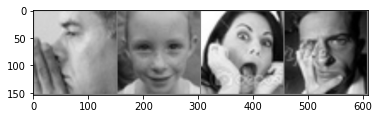

     Fear       Happy       Fear       Sad


In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print('  '.join('%5s' % "  "+classes[labels[j]] for j in range(4)))

In [11]:
class MLP(nn.Module):
  def __init__(self, num_classes=3):
    super(MLP,self).__init__()
    #input_shape = (256,3,150,150)
    # 256x67500 and 3072x64
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(3 * 150 * 150, 256),
      nn.ReLU(),
      nn.Linear(256, 256),
      nn.ReLU(),
      nn.Linear(256, 3)
    )


  def forward(self, input):
    '''Forward pass'''
    return self.layers(input)

In [12]:
model = MLP().to(device)

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [14]:
train_count = len(glob.glob(train_path+"/**/*.jpg"))
test_count = len(glob.glob(test_path+"/**/*.jpg"))
print(train_count,test_count)

3000 600


In [15]:
num_epochs=10
best_accuracy = 0.0

for epoch in range(num_epochs):

  model.train()
  train_accuracy = 0.0
  train_loss = 0.0

  for i, (images,labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
    
    optimizer.zero_grad()

    outputs = model(images)
    loss = loss_function(outputs,labels)
    loss.backward()
    optimizer.step()

    train_loss+= loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)

    train_accuracy += int(torch.sum(prediction==labels.data))

  train_accuracy = train_accuracy/train_count
  train_loss = train_loss/train_count


  model.eval()
  test_accuracy = 0.0

  for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
    outputs= model(images)
    _,prediction=torch.max(outputs.data,1)
    test_accuracy+= int(torch.sum(prediction==labels.data))

  test_accuracy = test_accuracy/test_count


  print("Epoch: "+str(epoch)+" Train_Loss: "+str(int(train_loss))[:5]+" Train_Accuracy: "+str(train_accuracy)[:5]+"Test_Accuracy: "+str(test_accuracy)[:5])

  if test_accuracy>best_accuracy:
    torch.save(model.state_dict(),"best_checkpoint.model")
    best_accuracy = test_accuracy



Epoch: 0 Train_Loss: 1 Train_Accuracy: 0.442Test_Accuracy: 0.473
Epoch: 1 Train_Loss: 0 Train_Accuracy: 0.546Test_Accuracy: 0.493
Epoch: 2 Train_Loss: 0 Train_Accuracy: 0.617Test_Accuracy: 0.51
Epoch: 3 Train_Loss: 0 Train_Accuracy: 0.668Test_Accuracy: 0.506
Epoch: 4 Train_Loss: 0 Train_Accuracy: 0.708Test_Accuracy: 0.513
Epoch: 5 Train_Loss: 0 Train_Accuracy: 0.725Test_Accuracy: 0.53
Epoch: 6 Train_Loss: 0 Train_Accuracy: 0.770Test_Accuracy: 0.531
Epoch: 7 Train_Loss: 0 Train_Accuracy: 0.781Test_Accuracy: 0.54
Epoch: 8 Train_Loss: 0 Train_Accuracy: 0.814Test_Accuracy: 0.553
Epoch: 9 Train_Loss: 0 Train_Accuracy: 0.842Test_Accuracy: 0.543


Test Accuracy is low because of the similarity of images. I dont have enough data to classify more correctly. At the same time, i dont have enough compute power to train with more complex CNN structure. Still, we have accuracy more than %50.